# LucidBench Run Comparison Analysis

This notebook compares the most recent two benchmark runs to identify statistically significant changes in performance metrics.

In [1]:
import os
import json
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set style for plots
#plt.style.use('seaborn')
sns.set_palette('husl')

## Load and Process Data

In [3]:
def load_run_data(run_dir):
    """Load all test results from a run directory."""
    data = []
    for root, dirs, files in os.walk(run_dir):
        for file in files:
            if file == 'test.json':
                try:
                    with open(os.path.join(root, file), 'r') as f:
                        content = f.read().strip()
                        if not content:  # Skip empty files
                            print(f"Warning: Empty file found at {os.path.join(root, file)}")
                            continue
                            
                        test_data = json.loads(content)
                        # Extract relevant metrics
                        if 'jobs' in test_data and len(test_data['jobs']) > 0:
                            job = test_data['jobs'][0]
                            metrics = {
                                'storage_type': test_data.get('storage_type', 'unknown'),
                                'device': test_data.get('device', 'unknown'),
                                'filesystem': test_data.get('filesystem', 'unknown'),
                                'test_type': test_data.get('test_type', 'unknown'),
                                'iops': job.get('read', {}).get('iops', 0) or job.get('write', {}).get('iops', 0),
                                'bandwidth': job.get('read', {}).get('bw', 0) or job.get('write', {}).get('bw', 0),
                                'latency_mean': job.get('read', {}).get('clat_ns', {}).get('mean', 0) or 
                                              job.get('write', {}).get('clat_ns', {}).get('mean', 0),
                                'timestamp': test_data.get('start_time')
                            }
                            data.append(metrics)
                except json.JSONDecodeError as e:
                    print(f"Error parsing JSON in {os.path.join(root, file)}: {str(e)}")
                    continue
                except Exception as e:
                    print(f"Unexpected error processing {os.path.join(root, file)}: {str(e)}")
                    continue
                    
    if not data:
        print(f"Warning: No valid data found in {run_dir}")
        return pd.DataFrame()  # Return empty DataFrame if no data
        
    return pd.DataFrame(data)

# Get the two most recent runs
results_dir = '../results'
runs = sorted([d for d in os.listdir(results_dir) if d.startswith('run_')])
latest_runs = runs[-2:]

# Load data for both runs
df1 = load_run_data(os.path.join(results_dir, latest_runs[0]))
df2 = load_run_data(os.path.join(results_dir, latest_runs[1]))

print(f"Comparing runs:\n{latest_runs[0]} vs {latest_runs[1]}")

Error parsing JSON in ../results/run_20250427_234135/SSD_sde_vfat_sequential_read/test.json: Expecting value: line 1 column 1 (char 0)
Error parsing JSON in ../results/run_20250427_234135/NVMe_nvme0n1_vfat_sequential_read/test.json: Expecting value: line 1 column 1 (char 0)
Error parsing JSON in ../results/run_20250427_234135/HDD_sda_vfat_sequential_read/test.json: Expecting value: line 1 column 1 (char 0)
Error parsing JSON in ../results/run_20250510_071739/SSD_sde_vfat_sequential_read/test.json: Expecting value: line 1 column 1 (char 0)
Error parsing JSON in ../results/run_20250510_071739/NVMe_nvme0n1_vfat_sequential_read/test.json: Expecting value: line 1 column 1 (char 0)
Error parsing JSON in ../results/run_20250510_071739/HDD_sda_vfat_sequential_read/test.json: Expecting value: line 1 column 1 (char 0)
Comparing runs:
run_20250427_234135 vs run_20250510_071739


## Statistical Analysis

In [4]:
def perform_statistical_test(group1, group2, metric):
    """Perform t-test and calculate effect size."""
    t_stat, p_value = stats.ttest_ind(group1, group2)
    # Calculate Cohen's d for effect size
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    pooled_se = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    cohens_d = (np.mean(group1) - np.mean(group2)) / pooled_se
    
    return {
        'metric': metric,
        't_statistic': t_stat,
        'p_value': p_value,
        'cohens_d': cohens_d,
        'mean_diff': np.mean(group1) - np.mean(group2),
        'mean_diff_percent': ((np.mean(group1) - np.mean(group2)) / np.mean(group2)) * 100
    }

# Perform statistical tests for each metric
metrics = ['iops', 'bandwidth', 'latency_mean']
results = []

for metric in metrics:
    result = perform_statistical_test(df1[metric], df2[metric], metric)
    results.append(result)

# Create results DataFrame
results_df = pd.DataFrame(results)
results_df['significant'] = results_df['p_value'] < 0.05
results_df['effect_size'] = pd.cut(results_df['cohens_d'], 
                                  bins=[-np.inf, -0.5, 0.5, np.inf],
                                  labels=['Small', 'Medium', 'Large'])

display(results_df)

,metric,t_statistic,p_value,cohens_d,mean_diff,mean_diff_percent,significant,effect_size
0,iops,0.001358,0.998918,0.000213,6.488564,0.042654,False,Medium
1,bandwidth,0.018490,0.985271,0.002905,2156.518519,0.418421,False,Medium
2,latency_mean,-0.007507,0.994019,-0.001180,-99399.599080,-0.137770,False,Medium


## Visualization of Changes

/tmp/ipykernel_750459/450631220.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels)


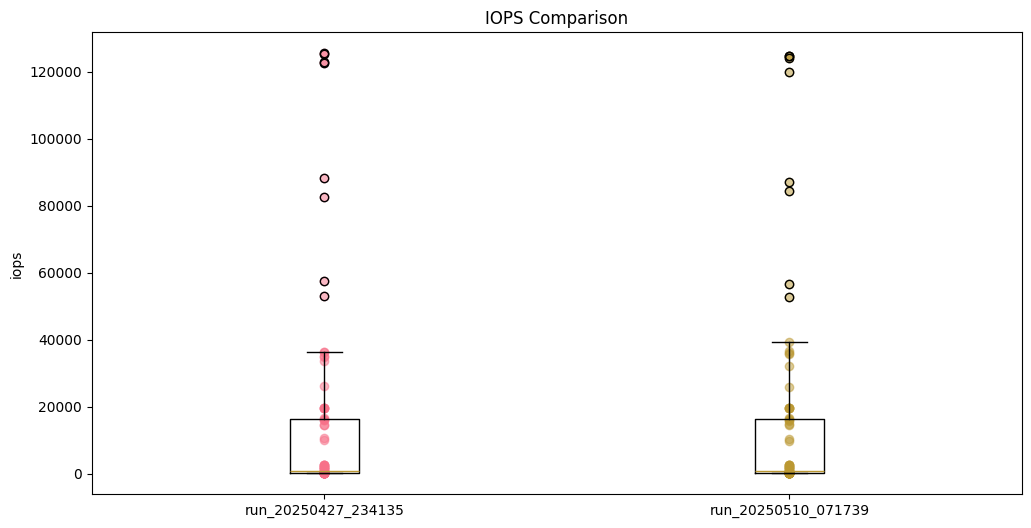

/tmp/ipykernel_750459/450631220.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels)


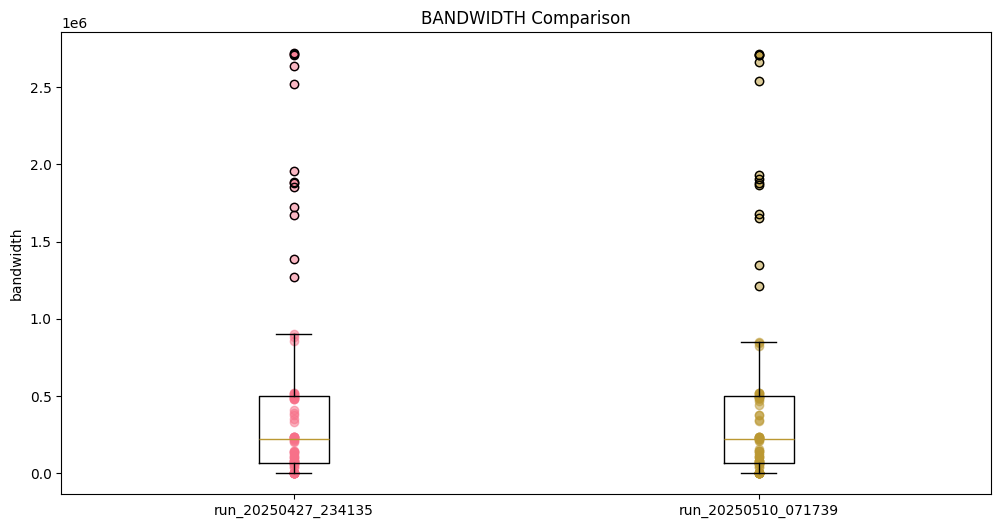

/tmp/ipykernel_750459/450631220.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels)


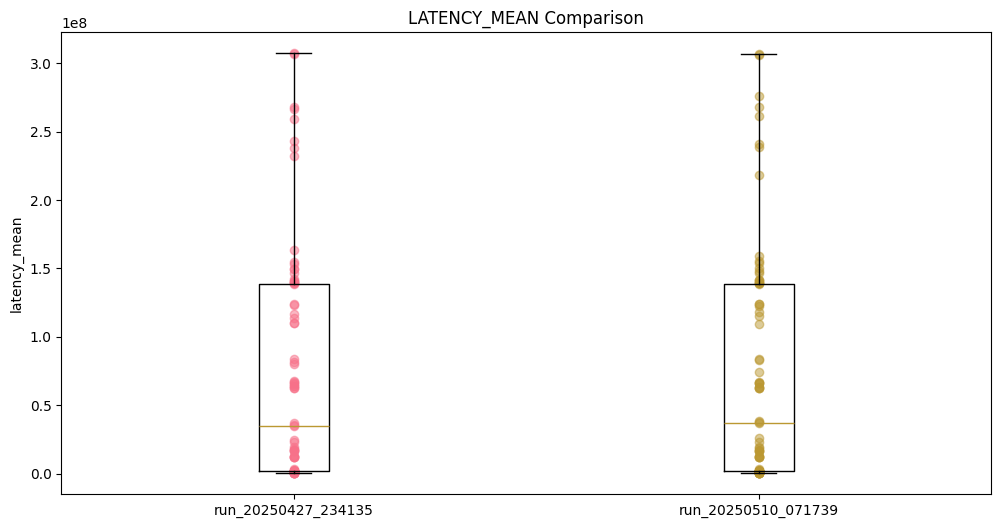

In [5]:
def plot_metric_comparison(df1, df2, metric):
    plt.figure(figsize=(12, 6))
    
    # Create box plots
    data = [df1[metric], df2[metric]]
    labels = [latest_runs[0], latest_runs[1]]
    
    plt.boxplot(data, labels=labels)
    plt.title(f'{metric.upper()} Comparison')
    plt.ylabel(metric)
    
    # Add individual data points
    for i, d in enumerate(data):
        plt.scatter([i+1] * len(d), d, alpha=0.5)
    
    plt.show()

# Plot comparisons for each metric
for metric in metrics:
    plot_metric_comparison(df1, df2, metric)

## Detailed Analysis by Filesystem and Test Type

In [6]:
def analyze_by_category(df1, df2, category):
    results = []
    for value in df1[category].unique():
        group1 = df1[df1[category] == value]
        group2 = df2[df2[category] == value]
        
        for metric in metrics:
            result = perform_statistical_test(group1[metric], group2[metric], metric)
            result[category] = value
            results.append(result)
    
    return pd.DataFrame(results)

# Analyze by filesystem
fs_results = analyze_by_category(df1, df2, 'filesystem')
fs_results['significant'] = fs_results['p_value'] < 0.05

print("\nAnalysis by Filesystem:")
display(fs_results)

# Analyze by test type
test_results = analyze_by_category(df1, df2, 'test_type')
test_results['significant'] = test_results['p_value'] < 0.05

print("\nAnalysis by Test Type:")
display(test_results)


Analysis by Filesystem:


,metric,t_statistic,p_value,cohens_d,mean_diff,mean_diff_percent,filesystem,significant
0,iops,0.009105,0.992848,0.004292,1.325755e+02,0.673499,vfat,False
1,bandwidth,-0.000205,0.999839,-0.000097,-1.566667e+01,-0.009278,vfat,False
2,latency_mean,0.037987,0.970168,0.017907,1.676040e+06,2.014495,vfat,False
3,iops,-0.003987,0.996854,-0.001628,-5.762293e+01,-0.352080,ext3,False
4,bandwidth,0.005458,0.995694,0.002228,1.634750e+03,0.340817,ext3,False
5,latency_mean,-0.000921,0.999274,-0.000376,-3.999044e+04,-0.046610,ext3,False
6,iops,0.020339,0.983956,0.008303,2.866351e+02,1.832255,xfs,False
7,bandwidth,-0.000275,0.999783,-0.000112,-9.550000e+01,-0.016767,xfs,False
8,latency_mean,0.007105,0.994395,0.002901,1.765928e+05,0.303678,xfs,False
9,iops,-0.011089,0.991253,-0.004527,-1.072649e+02,-0.986731,btrfs,False



Analysis by Test Type:


,metric,t_statistic,p_value,cohens_d,mean_diff,mean_diff_percent,test_type,significant
0,iops,0.048222,0.961779,0.014882,8.648313,1.277871,sequential_write,False
1,bandwidth,0.048222,0.961779,0.014882,8855.857143,1.277888,sequential_write,False
2,latency_mean,0.007123,0.994352,0.002198,201303.444549,0.202389,sequential_write,False
3,iops,0.025119,0.980085,0.007752,135.365107,0.939318,random_write,False
4,bandwidth,0.025128,0.980078,0.007755,541.666667,0.939685,random_write,False
5,latency_mean,-0.003952,0.996866,-0.001220,-132985.097914,-0.148600,random_write,False
6,iops,-0.002005,0.998412,-0.000668,-0.690423,-0.056788,sequential_read,False
7,bandwidth,-0.002006,0.998411,-0.000669,-707.055556,-0.056793,sequential_read,False
8,latency_mean,0.015466,0.987751,0.005155,281543.878472,0.440886,sequential_read,False
9,iops,-0.008153,0.993535,-0.002516,-118.394312,-0.278282,random_read,False


## Summary of Significant Changes

In [7]:
def print_significant_changes(results_df, category=None):
    significant = results_df[results_df['significant']]
    
    if len(significant) == 0:
        print(f"No significant changes found{' for ' + category if category else ''}")
        return
    
    print(f"\nSignificant changes{' for ' + category if category else ''}:")
    for _, row in significant.iterrows():
        direction = "increased" if row['mean_diff'] > 0 else "decreased"
        print(f"- {row['metric']}: {direction} by {abs(row['mean_diff_percent']):.2f}% "
              f"(p={row['p_value']:.3f}, d={row['cohens_d']:.2f})")

# Print overall significant changes
print_significant_changes(results_df)

# Print significant changes by filesystem
for fs in fs_results['filesystem'].unique():
    fs_data = fs_results[fs_results['filesystem'] == fs]
    print_significant_changes(fs_data, f"filesystem {fs}")

# Print significant changes by test type
for test in test_results['test_type'].unique():
    test_data = test_results[test_results['test_type'] == test]
    print_significant_changes(test_data, f"test type {test}")

No significant changes found
No significant changes found for filesystem vfat
No significant changes found for filesystem ext3
No significant changes found for filesystem xfs
No significant changes found for filesystem btrfs
No significant changes found for filesystem ntfs
No significant changes found for filesystem ext4
No significant changes found for filesystem ext2
No significant changes found for test type sequential_write
No significant changes found for test type random_write
No significant changes found for test type sequential_read
No significant changes found for test type random_read
